<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template and tests for an LSTM Auto-Encoder


In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.__version__

'2.2.0'

In [4]:
from astropy.cosmology import Planck18_arXiv_v2 as cosmo

In [5]:
import tensorflow_datasets as tfds

In [6]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [8]:
# # ! pip install tensorflow-probability==0.11.0
# ! pip install --user -e /global/homes/v/vboehm/codes/SDSS_PAE/    

#### load some SDSS data


In [9]:
import sdss_pae.sdss_dataset as sdss 

In [10]:
ds, info = tfds.load('sdss', data_dir='/global/cscratch1/sd/vboehm/Datasets/SDSS_BOSS_data_verylarge_IDs',with_info=True, split='train')

In [11]:
info


tfds.core.DatasetInfo(
    name='sdss',
    version=1.0.0,
    description='selected features from spAll and spZbest files 
'flux': measured spectrum in  
'inv_var': inverse variance
'and_mask': and mask (set to 1 for all non-zero entries)
'coeffs': c0, c1, npix. calculate wavelengths with `10.**(c0 + c1 * np.arange(npix))`
'label': type of object, 'STAR'==0, 'QSO'==1, 'GALAXY'==2
'redshift': object redshift estimate',
    homepage='https://www.sdss.org/science/data-release-publications/',
    features=FeaturesDict({
        'DEC': tf.float32,
        'MJD': tf.int32,
        'RA': tf.float32,
        'ZWARNING': tf.int32,
        'and_mask': Tensor(shape=(None, 1), dtype=tf.int32),
        'coeffs': Tensor(shape=(3, 1), dtype=tf.float32),
        'fiber': tf.int32,
        'filename': Text(shape=(), dtype=tf.string),
        'flux': Tensor(shape=(None, 1), dtype=tf.float32),
        'inv_var': Tensor(shape=(None, 1), dtype=tf.float32),
        'label': ClassLabel(shape=(), dtype=tf.in

In [12]:
#### settings
wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
select_by       = 2
de_redshift     = True
label           = 'galaxies_bins1000_wl3388-8318'

In [13]:
z_ref  = 0.1
ld_ref = cosmo.luminosity_distance(z_ref)

In [14]:
# filter dataset by redshifts and type

def filter_type_fn(x):
    if select_by is not None:
        return tf.math.equal(x['label'], select_by)
    else: return 1
    
def filter_zwarning_fn(x):
    if select_by is not None:
        return tf.math.equal(x['ZWARNING'], 0)
    else: return 1
    
def filter_redshift_fn(x):
    if select_by is not None:
        return tf.math.greater(x['redshift'], 0)
    else: return 1

ds = ds.filter(filter_type_fn)
ds = ds.filter(filter_redshift_fn)
ds = ds.filter(filter_zwarning_fn)

In [22]:
DATASET_SIZE=len(list(ds))
print('size of subselected data:', DATASET_SIZE)

size of subselected data: 478539


In [15]:
# computing maximum and minimum redhsift in the data sample, getting distribution of data sizes
# this doe not need to be run every time - especially if wavelength range is set by user

ii          = 0
min_wl      = 100
max_wl      = -100
num_npixs   = []
img_coeffs1 = []
img_coeffs2 = []
factors     = []
min_z       = 5
max_z       = -5
redshifts   = []

for image in tfds.as_numpy(ds):
    log10wl = image['coeffs'][0][0] + image['coeffs'][1][0] * np.arange(image['coeffs'][2][0])
    if de_redshift:
        log10wl = log10wl-np.log10(1+image['redshift'])
    if max(log10wl)>max_wl:
        max_wl= max(log10wl)
    if min(log10wl)<min_wl:
        min_wl=min(log10wl)
    redshifts.append(image['redshift'])
     
wl_range = (min_wl, max_wl) 

np.save('wl_range_galaxies_%s.npy'%label,wl_range)

In [16]:
min_wl, max_wl = wl_range
print(10**min_wl, 10**max_wl)

# compute number of pixels that span entire wl range:
npix_max = -(min_wl-max_wl)/np.unique(1e-4)
print(npix_max)

1195.8733456621314 10403.740659669438
[9395.04331558]


In [17]:
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

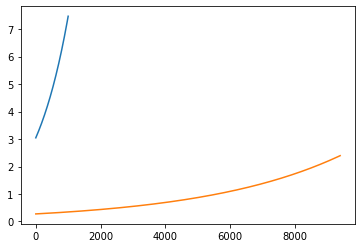

In [18]:
plt.plot(np.diff(new_wl))
plt.plot(np.diff(10**(min_wl+np.arange(npix_max)*1e-4)))

In [19]:
from scipy.stats import binned_statistic

In [20]:
raw_flux           = []
raw_noise          = []
raw_masks          = []
decs               = []
ras                = []
sublabel           = []

res_fluxes         = []
res_inv_vars       = []
res_masks          = []
redshifts          = []

SNs                = []

flag               = []

ii=0

for nn, image in enumerate(tfds.as_numpy(ds)):
    

        
    # compute wavelengths
    log10wl  = image['coeffs'][0][0] + image['coeffs'][1][0] * np.arange(image['coeffs'][2][0])
    log10wl  = log10wl
    wl       = 10**log10wl
    
    raw_flux.append(image['flux'])
    raw_noise.append(image['inv_var'])
    raw_masks.append(image['and_mask'])
    ##rescale flux by wavelength and distance
    factor   = (cosmo.luminosity_distance(image['redshift'])/ld_ref)**2
    #flux
    
    ### change that to before de-redshifting
    flux     = image['flux'][:,0]*factor*wl
    #inv_var
    inv_var  = image['inv_var'][:,0]/(wl*factor)**2
    
    wl/=(1.+image['redshift'])
    
    ## mask
    
    #mask
    mask           = np.squeeze(image['and_mask'])
    #mask pixels that are completely noise dominated (mask!)
    noise_         = np.squeeze(inv_var)
    ind            = np.where(noise_==0.)
    mask[ind]      = False 
    
    mask_ind = np.where(mask)

    if len(mask_ind[0])==0:
        continue
    ##resample
    #flux
    else:
        res_flux, _, _ = binned_statistic(wl[mask_ind], flux[mask_ind],bins=new_wl)
        


        noise          = 1./noise_[mask_ind]
        noise_, _, _   = binned_statistic(wl[mask_ind],noise,bins=new_wl)
        N, _, _        = binned_statistic(wl[mask_ind],values=np.zeros(len(wl[mask_ind])),statistic='count',bins=new_wl)
        new_mask_ind   = np.where(N==0)
        noise_          = noise_/N
        inv_var_res    = 1./noise_
        res_flux[new_mask_ind] = 0
        res_fluxes.append(res_flux)
    
        new_mask_cons = np.ones(len(new_wl)-1,dtype=np.int32)
        new_mask_cons[new_mask_ind] = 0

            
        res_masks.append(new_mask_cons)


        SN = np.sum(res_flux)/np.sqrt(np.sum(1./inv_var_res))
        SNs.append(SN)
        
        inv_var_res[new_mask_ind] = 0
        res_inv_vars.append(inv_var_res)

        redshifts.append(image['redshift'])
        ras.append(image['RA'])
        decs.append(image['DEC'])
        sublabel.append(image['sublabel'])
        
        ii+=1

In [23]:
np.save('/global/cscratch1/sd/vboehm/Datasets/SDSS_BOSS_preprocessed/%s.npy'%label,[res_fluxes,res_inv_vars,res_masks,redshifts,SNs, ras, decs, sublabel])